### **Train the fully connected layers for MNIST using AlexNet architecture**

The following notebook can be run on google Colab.

In [3]:
# If you don't use Windows, consider changing the install for PyTorch: https://pytorch.org/get-started/locally/
!pip3 install dill pyro-ppl==0.2.1 torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124


You should consider upgrading via the 'c:\users\tomva\onedrive\ku leuven\master theory and research\internship\rtnet\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
import os

import dill

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

%matplotlib inline

In [5]:
# Check Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


**Load the data and pre-processing**

In [19]:
# Here I reworked the original code to fit the pretrained AlexNet network input requirements.
# See: https://pytorch.org/hub/pytorch_vision_alexnet/

# Transformation steps for input data 
AlexTransform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # images need to be RGB, MNIST is in greyscale. Therefore needs to be converted to RGB
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # Also brings the tensor values in the range [0, 1] instead of [0, 255]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to mnist data
mnist_data_path = os.path.join("..", "data", 'mnist-data')

# Create a loader for training data and testing data
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(mnist_data_path, train=True, download=True, transform=AlexTransform),
        batch_size=500, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(mnist_data_path, train=False, download=True, transform=AlexTransform),
        batch_size=1, shuffle=False)

val_loader = torch.utils.data.DataLoader(
        datasets.MNIST(mnist_data_path, train=False, download=True, transform=AlexTransform),
        batch_size=500, shuffle=False)


**Check the images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


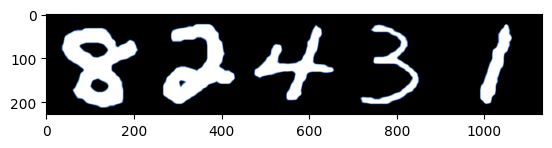

In [7]:
# Code to quickly check how the images turn out

# Get images 
samples, labels = next(iter(train_loader))

# Present a sample image
out = torchvision.utils.make_grid(samples[0:5]).squeeze().permute(1,2,0)

plt.imshow(out)

**Define the model**

AlexNet structure. Original RTNet code is disabled and replaced with a pretrained AlexNet (fully connected layers are still Bayesian)

In [8]:
# # AlexNet
# class alexnet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(96, 256, 5, 1, 2),
#             nn.ReLU(),
#             nn.MaxPool2d(3, 2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(256, 384, 3, 1, 1),
#             nn.ReLU()
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(384, 384, 3, 1, 1),
#             nn.ReLU()
#         )
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(384, 256, 3, 1, 1),
#             nn.ReLU(),
#             nn.MaxPool2d(3, 2)
#         )

#         self.classifier.1 = nn.Linear(256 * 6 * 6, 4096)
#         self.fc2 = nn.Linear(4096, 4096)
#         self.fc3 = nn.Linear(4096, 10)

#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.conv2(out)
#         out = self.conv3(out)
#         out = self.conv4(out)
#         out = self.conv5(out)
#         out = out.view(out.size(0), -1)

#         out = F.relu(self.classifier.1(out))  # 256*6*6 -> 4096
#         out = F.dropout(out, 0.5)
#         out = F.relu(self.fc2(out))
#         out = F.dropout(out, 0.5)
#         out = self.fc3(out)
#         # out = F.log_softmax(out, dim=1)

#         return out

In [9]:
# Load pretrained model
mod = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

In [10]:
# Change last layer to reflect MNIST categories
mod_fc = mod.classifier[-1] 
num_ftrs = mod_fc.in_features # Get the amount of input features for the last layer

# Update to 10 possible outputs
mod.classifier[-1] = nn.Linear(num_ftrs, 10)


All layers are frozen, except for the fully connected layers. 

In [11]:
# Freeze all layers first
for param in mod.parameters():
    param.requires_grad=False

# Unfreeze all fully connected layers
for layer in mod.classifier:
    if isinstance(layer, torch.nn.Linear):  # Check if the layer is a fully connected layer
        for param in layer.parameters():
            param.requires_grad = True  # Unfreeze the fully connected layer

# Check the requires_grad status of each layer
for name, param in mod.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

features.0.weight: requires_grad = False
features.0.bias: requires_grad = False
features.3.weight: requires_grad = False
features.3.bias: requires_grad = False
features.6.weight: requires_grad = False
features.6.bias: requires_grad = False
features.8.weight: requires_grad = False
features.8.bias: requires_grad = False
features.10.weight: requires_grad = False
features.10.bias: requires_grad = False
classifier.1.weight: requires_grad = True
classifier.1.bias: requires_grad = True
classifier.4.weight: requires_grad = True
classifier.4.bias: requires_grad = True
classifier.6.weight: requires_grad = True
classifier.6.bias: requires_grad = True


In [12]:
# Create an instance of the model and send to GPU if available
net = mod.to(device)
# Define softmax function
log_softmax = nn.LogSoftmax(dim=1)

Model function for pyro. Pyro is a probabilistic programming language which brings Bayesian statistics to PyTorch, simply speaking.
It uses variational inference to approximate the real posterior distribution of the network weights and biases. This way of doing Bayesian inference requires a model structure (defined as Python function), and a definition for the variational distribution, or a 'guide' in Pyro terms. 

*I asked ChatGPT to explain further to save me some time :) (seems generally correct to me):*

The model function represents the generative process of the data and defines the prior distributions over the unknown variables. It outlines how the observed data is generated from latent variables through probabilistic sampling. The model is essentially a probabilistic program where you specify both observed and latent random variables.

The guide function approximates the posterior distribution over the latent variables, given the observed data. Instead of directly computing the posterior, which is often intractable, the guide defines an easier-to-compute distribution (usually parameterized) that approximates the true posterior. The guide is optimized during inference to make the approximation as close as possible to the actual posterior.

In summary, the model specifies the data generation process, and the guide provides a flexible approximation to the posterior distribution, allowing Pyro to perform variational inference.

In [13]:
def model(x_data, y_data):

    fc1Layer_w = Normal(loc=torch.ones_like(net.classifier[1].weight), scale=torch.ones_like(net.classifier[1].weight))
    fc1Layer_b = Normal(loc=torch.ones_like(net.classifier[1].bias), scale=torch.ones_like(net.classifier[1].bias))

    fc2Layer_w = Normal(loc=torch.ones_like(net.classifier[4].weight), scale=torch.ones_like(net.classifier[4].weight))
    fc2Layer_b = Normal(loc=torch.ones_like(net.classifier[4].bias), scale=torch.ones_like(net.classifier[4].bias))

    fc3Layer_w = Normal(loc=torch.ones_like(net.classifier[6].weight), scale=torch.ones_like(net.classifier[6].weight))
    fc3Layer_b = Normal(loc=torch.ones_like(net.classifier[6].bias), scale=torch.ones_like(net.classifier[6].bias))

    priors = {'classifier[1].weight': fc1Layer_w,
              'classifier[1].bias': fc1Layer_b,
              'classifier[4].weight': fc2Layer_w,
              'classifier[4].bias': fc2Layer_b,
              'classifier[6].weight': fc3Layer_w,
              'classifier[6].bias': fc3Layer_b}

    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()

    lhat = log_softmax(lifted_reg_model(x_data))

    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

Guide function for pyro

In [14]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):

    # First fully connected layer weight distribution priors
    fc1w_mu = torch.randn_like(net.classifier[1].weight)
    fc1w_sigma = torch.randn_like(net.classifier[1].weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1Layer_w = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param).independent(1)

    # First fully connected layer bias distribution priors
    fc1b_mu = torch.randn_like(net.classifier[1].bias)
    fc1b_sigma = torch.randn_like(net.classifier[1].bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1Layer_b = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)

    # Second fully connected layer weight distribution priors
    fc2w_mu = torch.randn_like(net.classifier[4].weight)
    fc2w_sigma = torch.randn_like(net.classifier[4].weight)
    fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
    fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma))
    fc2Layer_w = Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param).independent(1)

    # Second fully connected layer bias distribution priors
    fc2b_mu = torch.randn_like(net.classifier[4].bias)
    fc2b_sigma = torch.randn_like(net.classifier[4].bias)
    fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
    fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma))
    fc2Layer_b = Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param)

    # Third fully connected layer weight distribution priors
    fc3w_mu = torch.randn_like(net.classifier[6].weight)
    fc3w_sigma = torch.randn_like(net.classifier[6].weight)
    fc3w_mu_param = pyro.param("fc3w_mu", fc3w_mu)
    fc3w_sigma_param = softplus(pyro.param("fc3w_sigma", fc3w_sigma))
    fc3Layer_w = Normal(loc=fc3w_mu_param, scale=fc3w_sigma_param).independent(1)

    # Third fully connected layer bias distribution priors
    fc3b_mu = torch.randn_like(net.classifier[6].bias)
    fc3b_sigma = torch.randn_like(net.classifier[6].bias)
    fc3b_mu_param = pyro.param("fc3b_mu", fc3b_mu)
    fc3b_sigma_param = softplus(pyro.param("fc3b_sigma", fc3b_sigma))
    fc3Layer_b = Normal(loc=fc3b_mu_param, scale=fc3b_sigma_param)

    priors = {'classifier[1].weight': fc1Layer_w,
              'classifier[1].bias': fc1Layer_b,
              'classifier[4].weight': fc2Layer_w,
              'classifier[4].bias': fc2Layer_b,
              'classifier[6].weight': fc3Layer_w,
              'classifier[6].bias': fc3Layer_b}

    lifted_module = pyro.random_module("module", net, priors)

    return lifted_module()

**Training a model. You can skip this and instead load an earlier trained model in the next block**

In [15]:
optim = Adam({'lr': 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

Bit of testcode

In [16]:
test_model = guide(None, None)
pyro.get_param_store().get_all_param_names()

dict_keys(['fc1w_mu', 'fc1w_sigma', 'fc1b_mu', 'fc1b_sigma', 'fc2w_mu', 'fc2w_sigma', 'fc2b_mu', 'fc2b_sigma', 'fc3w_mu', 'fc3w_sigma', 'fc3b_mu', 'fc3b_sigma', 'module$$$features.0.weight', 'module$$$features.0.bias', 'module$$$features.3.weight', 'module$$$features.3.bias', 'module$$$features.6.weight', 'module$$$features.6.bias', 'module$$$features.8.weight', 'module$$$features.8.bias', 'module$$$features.10.weight', 'module$$$features.10.bias', 'module$$$classifier.1.weight', 'module$$$classifier.1.bias', 'module$$$classifier.4.weight', 'module$$$classifier.4.bias', 'module$$$classifier.6.weight', 'module$$$classifier.6.bias'])

Function for evaluating the model during training

In [ ]:
def evaluate_model(val_loader):
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation
        for batch_id, data in enumerate(val_loader):
            x_val, y_val = data[0].to(device), data[1].to(device)
            # Get predictions from sampled models
            yhats = [guide(None, None)(x_val) for _ in range(5)]
            avg_yhat = torch.mean(torch.stack(yhats), dim=0)  # Average over the sampled models
            
            # Get predicted classes
            _, predicted = torch.max(avg_yhat, 1)
            total += y_val.size(0)  # Total samples
            correct += (predicted == y_val).sum().item()  # Correct predictions

    accuracy = round(correct / total *100, 2)
    return accuracy

The actual training

In [113]:
num_iterations = 3
loss = 0
accuracies = []
for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].to(device), data[1].to(device))
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    # Evaluate the model
    accuracy = evaluate_model(val_loader)
    accuracies.append(accuracy)

    print("Epoch ", j, " Loss: ", total_epoch_loss_train, "Validation accuracy: ", accuracy)

Epoch  0  Loss  9.087833288574219
Epoch  1  Loss  120.18014262491862
Epoch  2  Loss  5.456605379231771


In [31]:
val_data, val_labels = next(iter(val_loader))
val_data.shape

torch.Size([500, 3, 224, 224])

**Load a model if desired**

In [30]:
# Loading the model and parameters without using the regular loading function
# This is because parameters had to be stored using dill package, instead of pickle.
# Saving the parameters in the normal way resulted in errors due to weakref objects (which cannot be serialized by pickle)

load_model = True

model_num = "02"

if load_model:
    # Load model
    load_model_path = os.path.join("..", "results", "pretrained_models", "model_" + model_num + ".pt")
    saved_model_dict = torch.load(load_model_path) 
    net.load_state_dict(saved_model_dict['model'])
    guide = saved_model_dict['guide']
    
    # Load parameters
    load_path_params = os.path.join("..", "results", "pretrained_models", "model_" + model_num + "_params.pt")
    with open(load_path_params, 'rb') as file:
        loaded_params = dill.load(file)
    
    # Store parameters from loaded file into parameter store.
    for param_name, param_tensor in loaded_params.items():
        pyro.param(param_name, param_tensor)
        
    

C:\Users\tomva\AppData\Local\Temp\ipykernel_23704\1438135054.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_dict = torch.load(load_model_path)
c:\Users\tom

**Evaluation**

Predictions are inaccurate!

True label: tensor([7])


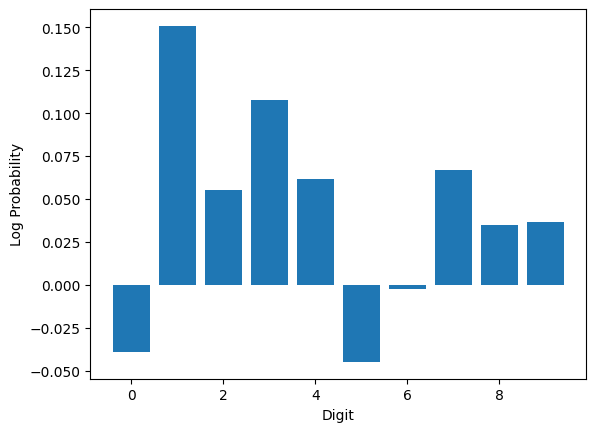

In [21]:
sampled_models = [guide(None, None) for _ in range(5)]

sample_data, labels = next(iter(test_loader))
print("True label:", labels)
# Predicted class
yhats = sampled_models[1](sample_data.to(device))

# Graph predictions
x_vals = np.array([i for i in range(10)])
plt.bar(x_vals, yhats.squeeze().cpu().detach().numpy())
plt.xlabel("Digit")
plt.ylabel("Log Probability?")
plt.show()


It is strange that the sampled models give equal predictions!

In [26]:
sampled_models[1](sample_data.to(device)) == sampled_models[2](sample_data.to(device))

tensor([[True, True, True, True, True, True, True, True, True, True]],
       device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


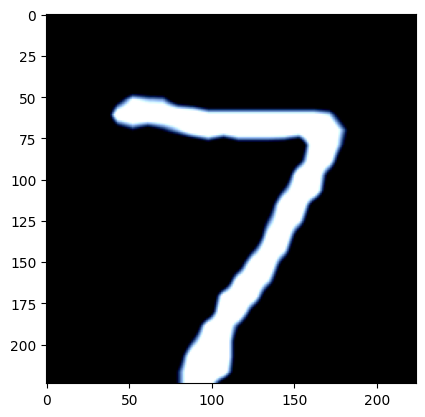

In [20]:
plt.imshow(sample_data.squeeze().permute(1,2,0))

This is original code from the RTNet authors. I get an accuracy of 11% (chance level)

In [42]:
net.eval()
num_samples = 3
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return torch.argmax(mean, dim=1)


print('Prediction when network is forced to predict')
correct = 0
total = 0

all_labels = []
all_predicted = []
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.to(device))
    total += labels.size(0)
    correct += (predicted == labels.to(device)).sum().item()
    all_labels.append(labels)
    all_predicted.append(predicted)
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 11 %


**Save the model**

In [114]:

#Paths to folder and file for saving
path = os.path.join("..", "results", "pretrained_models")

# Create folder if not already existent
if not os.path.isdir(path):
    os.makedirs(path)

model_num = '02'

torch.save({"model" : net.state_dict(), "guide" : guide}, path + "/model_" + model_num + ".pt")

try:
    pyro.get_param_store().save(path + "/model_" + model_num + "_params.pt")

except TypeError:
    print("Weakref object was detected, using alternative way to store parameters...")
    # Use dill to store parameters if weakref object was detected (which causes a TypeError)
    params = pyro.get_param_store()
    param_keys = list(params.get_all_param_names())
    # Create dictionary manually
    params_workaround = {param_key: params.get_param(param_key) for param_key in param_keys}
    # Store using dill instead of pickle (dill can handle weakref objects)
    save_path = os.path.join("results","pretrained_models", "model_"+model_num+"_params.pt")
    with open(save_path, 'wb') as file:
        dill.dump(params_workaround, file)

    print("\nParameters have been stored using dill package!")
    

Weakref object was detected, using alternative way to store parameters...

Parameters have been stored using dill package!
